# Playing Frozen Lake with Q-learning

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. 

At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:

SFFF       
FHFH       
FFFH       
HFFG

S: starting point, safe  
F: frozen surface, safe  
H: hole, fall to your doom  
G: goal, where the frisbee is located

The episode ends when you reach the goal or fall in a hole.  
You receive a reward of 1 if you reach the goal, and zero otherwise.

Actions:  
0: LEFT  
1: DOWN  
2: RIGHT  
3: UP  

`is_slippery`: True/False. If True, will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

https://www.gymlibrary.ml/environments/toy_text/frozen_lake/?highlight=frozenlake

In [1]:
%pip install --upgrade gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 732 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.25.1-py3-none-any.whl size=849048 sha256=c14f23c0c8ca9fa3ead26bc8be7392547109e23416019d008e59603a59a22efd
  Stored in directory: /root/.cache/pip/wheels/0e/2d/04/f964345f96b1348723057d60011be1e48885a027c9c5b92210
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
gym.__version__

'0.25.1'

In [ ]:
env = gym.make("FrozenLake-v1", new_step_api=True, is_slippery=False)

In [ ]:
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={'map_name': '4x4', 'is_slippery': False}, namespace=None, name='FrozenLake', version=1)

In [ ]:
env.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [ ]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))
#print(q_table)

In [ ]:
num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

In [ ]:
rewards_all_episodes = []

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):       
        
        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = env.action_space.sample()

        new_state, reward, done, _, info = env.step(action)

        # Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        
        state = new_state
        rewards_current_episode += reward        
        
        if done == True: 
            break
           
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)    
    
    rewards_all_episodes.append(rewards_current_episode)

# Calculate and print the average reward per thousand episodes
rewards_per_thosand_episodes = np.split(np.array(rewards_all_episodes),num_episodes/1000)
count = 1000
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thosand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000    

# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)

********Average reward per thousand episodes********

1000 :  0.2610000000000002
2000 :  0.7190000000000005
3000 :  0.9000000000000007
4000 :  0.9660000000000007
5000 :  0.9790000000000008
6000 :  0.9830000000000008
7000 :  0.9950000000000008
8000 :  0.9890000000000008
9000 :  0.9920000000000008
10000 :  0.9860000000000008


********Q-table********

[[0.94148015 0.95099005 0.93206535 0.94148015]
 [0.94148015 0.         0.60634858 0.83463864]
 [0.83194283 0.17892079 0.0158612  0.41394516]
 [0.1332636  0.         0.0032877  0.        ]
 [0.95099005 0.96059601 0.         0.94148015]
 [0.         0.         0.         0.        ]
 [0.         0.78607882 0.         0.13285992]
 [0.         0.         0.         0.        ]
 [0.96059601 0.         0.970299   0.95099004]
 [0.96059588 0.9801     0.98009998 0.        ]
 [0.9101944  0.99       0.         0.49007337]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.98009984 0.99       0.

In [ ]:
# Watch our agent play Frozen Lake by playing the best action 
# from each state according to the Q-table

state = env.reset()
done = False

for step in range(max_steps_per_episode):        
    clear_output(wait=True)
    env.render()
    time.sleep(0.3)
    
    action = np.argmax(q_table[state,:])        
    new_state, reward, done, _, info = env.step(action)
    
    if done:
        clear_output(wait=True)
        env.render()
        if reward == 1:
            print("****You reached the goal!****")
            time.sleep(1)
        else:
            print("****You fell through a hole!****")
            time.sleep(1)
        clear_output(wait=True)
        break
        
    state = new_state
    
env.close()

****You reached the goal!****


# 8x8

In [3]:
env = gym.make("FrozenLake-v1", new_step_api=True, is_slippery=False, map_name='8x8')
env.desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'H', b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'H', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'G']], dtype='|S1')

/usr/local/lib/python3.7/dist-packages/gym/core.py:269: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:96: DeprecationWarning: WARN: Function `rng.seed(seed)` is marked as deprecated and will be removed in the future. Please use `rng, seed = gym.utils.seeding.np_random(seed)` to create a separate generator instead.
  "Function `rng.seed(seed)` is marked as deprecated "


********Average reward per thousand episodes********

1000 :  0.1420000000000001
2000 :  0.5140000000000003
3000 :  0.7740000000000006
4000 :  0.8730000000000007
5000 :  0.9450000000000007
6000 :  0.9630000000000007
7000 :  0.9740000000000008
8000 :  0.9840000000000008
9000 :  0.9920000000000008
10000 :  0.9940000000000008


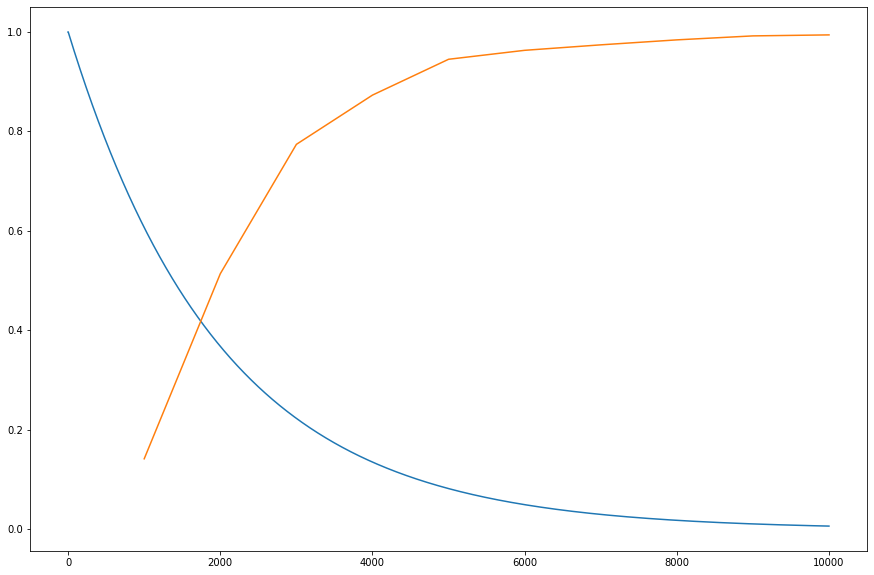

In [4]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.01
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0
exploration_decay_rate = 0.0005

RANDOM_SEED = 0
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
env.action_space.seed(RANDOM_SEED)
env.action_space.np_random.seed(RANDOM_SEED)

q_table = np.zeros((state_space_size, action_space_size))

rewards_all_episodes = []
all_episodes_info = []
output = []

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0
    step_count = 0
    steps = []
    for step in range(max_steps_per_episode):       
        #print(episode, step)

        #env.action_space.seed( (step * 100000) + episode )

        step_count += 1

        # Exploration-exploitation trade-off
        exploration_rate_threshold = random.uniform(0, 1)

        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = env.action_space.sample()

        steps.append(action)
        new_state, reward, done, _, info = env.step(action)

        # Update Q-table for Q(s,a)
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        
        state = new_state
        rewards_current_episode += reward        
        
        if done == True: 
            if reward == 1:
              output.append(q_table.copy())
            break
    
    all_episodes_info.append([episode, exploration_rate, step_count, reward, steps])

    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)    
    
    rewards_all_episodes.append(rewards_current_episode)

# Calculate and print the average reward per thousand episodes
rewards_per_thosand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/1000)
count = 1000
print("********Average reward per thousand episodes********\n")
for r in rewards_per_thosand_episodes:
    print(count, ": ", str(sum(r/1000)))
    count += 1000    

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot([i[0] for i in all_episodes_info], [i[1] for i in all_episodes_info])
plt.plot(range(1000, num_episodes + 1, 1000), [ sum(i)/1000 for i in rewards_per_thosand_episodes ] )

#### Last q_table

In [9]:
import json
q = output[-1].round(2)
for n in range(8):
  print([ json.dumps(list(i)).ljust(25) for i in q[8*n:8*(n+1)] ])

['[0.71, 0.33, 0.88, 0.69] ', '[0.68, 0.52, 0.89, 0.68] ', '[0.7, 0.67, 0.9, 0.71]   ', '[0.72, 0.74, 0.9, 0.73]  ', '[0.72, 0.91, 0.66, 0.74] ', '[0.19, 0.9, 0.14, 0.15]  ', '[0.08, 0.84, 0.12, 0.07] ', '[0.11, 0.87, 0.13, 0.1]  ']
['[0.02, 0.0, 0.58, 0.06]  ', '[0.03, 0.01, 0.82, 0.1]  ', '[0.13, 0.03, 0.89, 0.24] ', '[0.23, 0.0, 0.91, 0.31]  ', '[0.73, 0.5, 0.92, 0.8]   ', '[0.8, 0.74, 0.93, 0.72]  ', '[0.81, 0.84, 0.94, 0.62] ', '[0.83, 0.95, 0.86, 0.68] ']
['[0.0, 0.0, 0.0, 0.03]    ', '[0.0, 0.0, 0.0, 0.1]     ', '[0.0, 0.0, 0.0, 0.21]    ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.74, 0.14]   ', '[0.1, 0.0, 0.92, 0.25]   ', '[0.24, 0.3, 0.95, 0.43]  ', '[0.86, 0.96, 0.91, 0.9]  ']
['[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.0, 0.06]    ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.17, 0.92, 0.21]  ', '[0.79, 0.97, 0.93, 0.9]  ']
['[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.0, 0.0, 0.0]     ', '[0.0, 0.

#### See how probabilities of actions are updated

In [ ]:
for q_table in output:    
  q = q_table.round(2)
  for n in range(8):
    print([ json.dumps(list(i)).ljust(25) for i in q[8*n:8*(n+1)] ])
  time.sleep(0.1)
  clear_output(wait=True)